In [1]:
import pandas as pd
house = pd.read_csv(
    'https://raw.githubusercontent.com/rasbt/python-machine-learning-book-2nd-edition/master/code/ch10/housing.data.txt',
    header=None, sep='\s+'
)
house.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

house.describe() # descriptive statistics

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

X = house.iloc[:, :-1].values
y = house['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.5, 
    random_state=1
)

gbrg = GradientBoostingRegressor(
    n_estimators=120,
    max_depth=3,
)
gbrg.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrg.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)
gbrg_best = GradientBoostingRegressor(
    n_estimators=best_n_estimators,
    max_depth=3
)
gbrg_best.fit(X_train, y_train)
y_train_pred = gbrg_best.predict(X_train)
y_test_pred = gbrg_best.predict(X_test)

print('RMSE Train: %0.3f, test : %0.3f' % (root_mean_squared_error(y_train, y_train_pred), root_mean_squared_error(y_test, y_test_pred)))
print(gbrg_best.feature_importances_)

RMSE Train: 0.898, test : 3.286
[5.54698306e-02 4.34460608e-05 5.07396132e-03 6.21104369e-04
 1.53826434e-02 2.65950552e-01 1.04241290e-02 7.13196850e-02
 2.20082707e-03 1.86861439e-02 2.49043614e-02 1.62116193e-02
 5.13711697e-01]


# 부분의존도

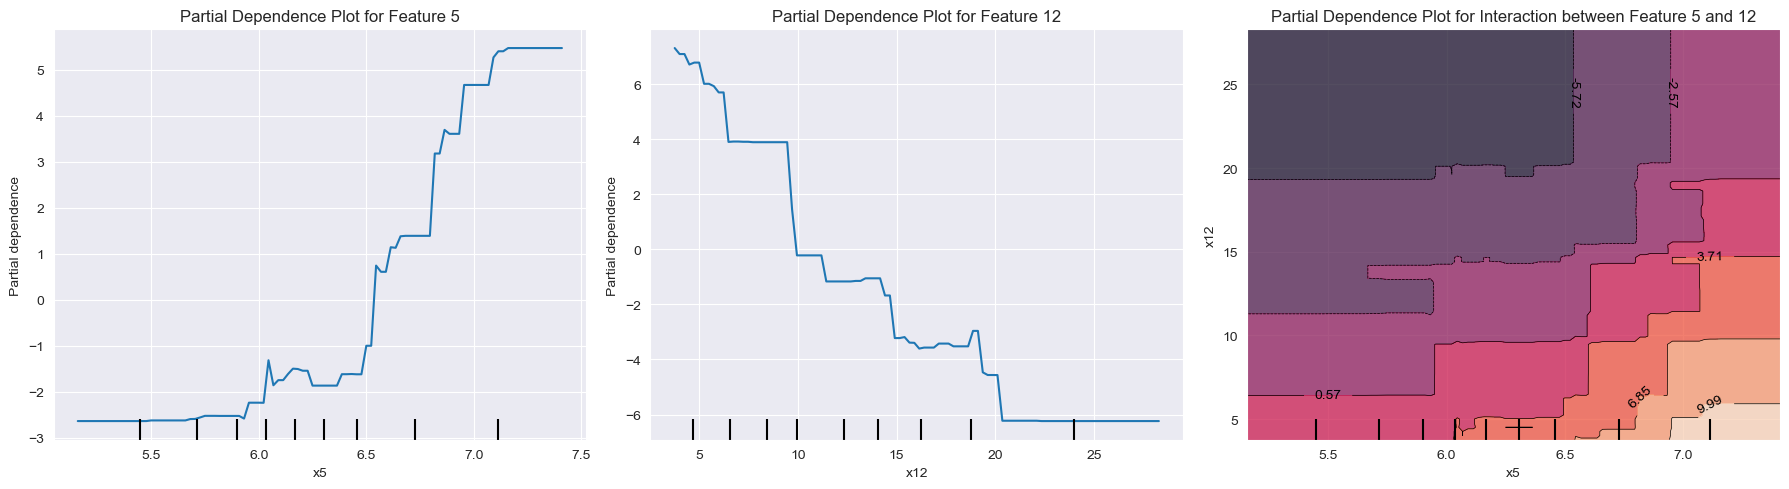

In [20]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot partial dependence for feature 5
PartialDependenceDisplay.from_estimator(gbrg_best, X_train, features=[5], ax=ax[0])
ax[0].set_title('Partial Dependence Plot for Feature 5')

# Plot partial dependence for feature 12
PartialDependenceDisplay.from_estimator(gbrg_best, X_train, features=[12], ax=ax[1])
ax[1].set_title('Partial Dependence Plot for Feature 12')

# Plot partial dependence for interaction between features 5 and 12
PartialDependenceDisplay.from_estimator(gbrg_best, X_train, features=[(5, 12)], ax=ax[2])
ax[2].set_title('Partial Dependence Plot for Interaction between Feature 5 and 12')

plt.tight_layout()
plt.show()

# Decision Tree Regressor

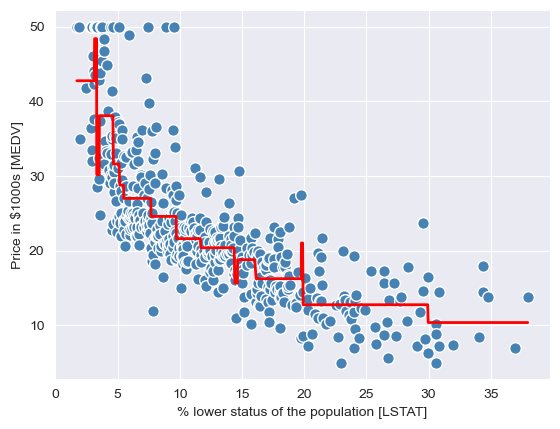

In [36]:
from sklearn.tree import DecisionTreeRegressor

X = house[[house.columns[np.argmax(gbrg_best.feature_importances_)]]].values

tree = DecisionTreeRegressor(max_depth=4)
tree.fit(X, y)
sort_idx = X.flatten().argsort() # argsort : 배열의 요소들을 오름차순으로 정렬했을 때의 인덱스를 반환
def lin_regplot(X, y, model):
    plt.scatter(X,y, c='steelblue', edgecolors='white', s=70)
    plt.plot(X, model.predict(X), color='red', lw=2)

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

# Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

X = house.iloc[:, :-1].values
y = house['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, 
    random_state=1
)

forest = RandomForestRegressor(
    n_estimators=500,
    criterion='squared_error',
    max_depth=5,
    random_state=1
)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [47]:
from sklearn.metrics import root_mean_squared_error, r2_score

print('RMSE Train: %0.3f, test : %0.3f' % (root_mean_squared_error(y_train, y_train_pred), root_mean_squared_error(y_test, y_test_pred)))
print('R^2 Train: %0.3f, test : %0.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

RMSE Train: 2.211, test : 3.108
R^2 Train: 0.940, test : 0.895


# residual plot

In [49]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_train_pred, y=y_train_pred - y_train,
    mode='markers', 
    name='Training Data'
))
fig.add_trace(go.Scatter(
    x=y_test_pred, y=y_test_pred - y_test,
    mode='markers', 
    name='Test Data'
))
fig.update_layout(
    width=600, 
    height=400,
    title_text='Residual Plots versus predicted values',
    title_x=0.5,
)
fig.update_xaxes(title_text='predicted values')
fig.update_yaxes(title_text='residuals')
fig.show()